In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [4]:
# === 1. Funzione universale per scaricare e parse Eurostat JSON ===
def fetch_eurostat_data(dataset, filters):
    base_url = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data"
    query_parts = []
    for key, value in filters.items():
        if isinstance(value, list):
            query_parts.extend([f"{key}={v}" for v in value])
        else:
            query_parts.append(f"{key}={value}")
    query_str = "&".join(query_parts)
    url = f"{base_url}/{dataset}?{query_str}&format=JSON"
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Errore {response.status_code}: {response.text}")
    data = response.json()
    dims = data["dimension"]
    dim_order = data["id"]
    dim_labels = {dim: dims[dim]["category"]["label"] for dim in dim_order}
    dim_keys = {dim: list(dim_labels[dim].keys()) for dim in dim_order}
    combinations = list(product(*[dim_keys[dim] for dim in dim_order]))
    records = []
    for i, combo in enumerate(combinations):
        if str(i) in data["value"]:
            record = {}
            for dim, key in zip(dim_order, combo):
                record[f"{dim}_code"] = key
                record[f"{dim}_label"] = dim_labels[dim][key]
            record["value"] = data["value"][str(i)]
            records.append(record)
    df = pd.DataFrame(records)
    if 'time_label' in df.columns:
        df['time'] = pd.to_datetime(df['time_label'], errors='coerce')
        mask_quarter = df['time'].isna() & df['time_label'].str.contains('Q')
        df.loc[mask_quarter, 'time'] = pd.PeriodIndex(df.loc[mask_quarter, 'time_label'], freq='Q').to_timestamp()
    return df

## PIL reale (CLV_I20) - IT vs DE

In [ ]:
df = fetch_eurostat_data(
    dataset='namq_10_gdp',
    filters={
        'geo': ['IT','DE'],
        'unit': 'CLV_I20', # CLV10_MEUR,CLV15_MEUR, CLV20_MEUR ....CLV_I20
        's_adj': 'SCA',
        'na_item': ['B1GQ']
    }
)

<positron-console-cell-40>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


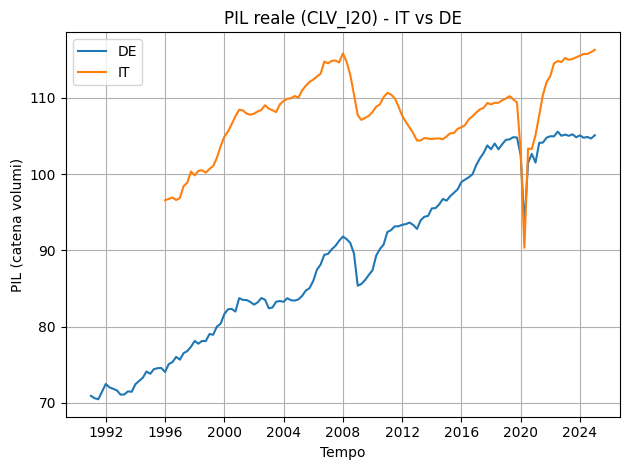

In [41]:
import matplotlib.pyplot as plt

for geo, gdf in df.groupby('geo_code'):
    gdf_sorted = gdf.sort_values('time')
    plt.plot(gdf_sorted['time'], gdf_sorted['value'], label=geo)

plt.title("PIL reale (CLV_I20) - IT vs DE")
plt.xlabel("Tempo")
plt.ylabel("PIL (catena volumi)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


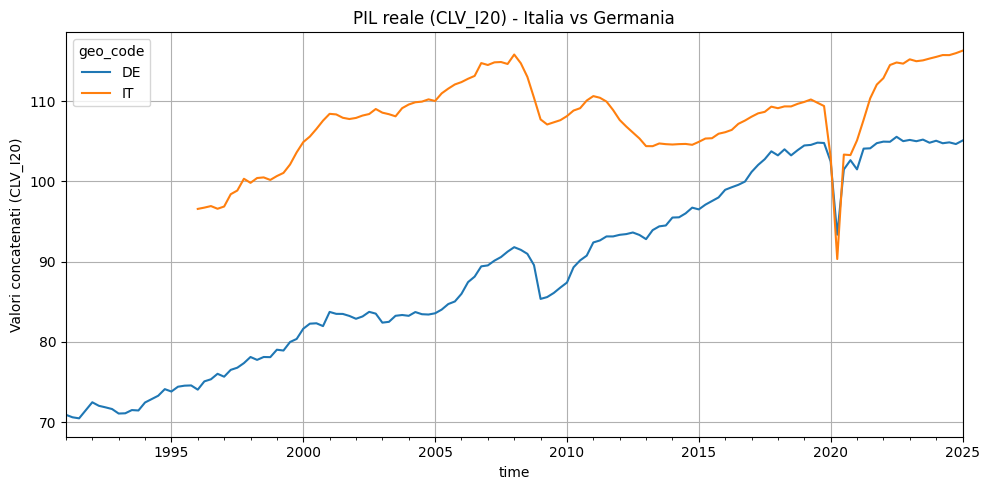

In [42]:
df_pivot = df.pivot_table(index='time', columns='geo_code', values='value')
df_pivot.plot(title='PIL reale (CLV_I20) - Italia vs Germania', figsize=(10, 5), grid=True)
plt.ylabel("Valori concatenati (CLV_I20)")
plt.tight_layout()
plt.show()


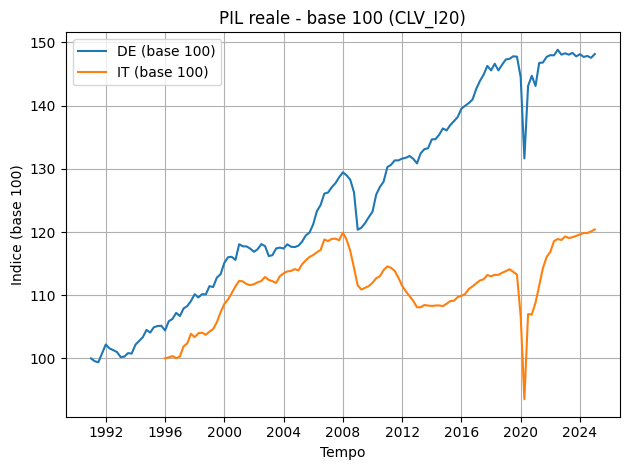

In [43]:
df_base100 = df.copy()
df_base100['value'] = df_base100.groupby('geo_code')['value'].transform(lambda x: x / x.iloc[0] * 100)

# plot
for geo, gdf in df_base100.groupby('geo_code'):
    plt.plot(gdf['time'], gdf['value'], label=f"{geo} (base 100)")

plt.title("PIL reale - base 100 (CLV_I20)")
plt.xlabel("Tempo")
plt.ylabel("Indice (base 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


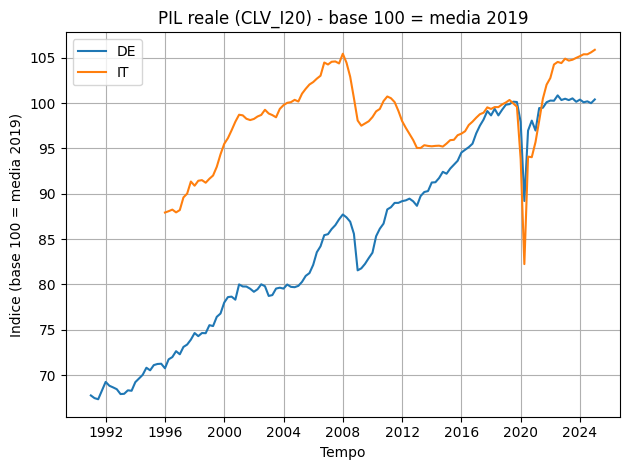

In [44]:
mask_2019 = df['time'].dt.year == 2019

# Calcola la media 2019 per ciascun paese
base_values = df[mask_2019].groupby('geo_code')['value'].mean()

# Normalizza rispetto alla media 2019
df_base100 = df.copy()
df_base100['value_base100'] = df_base100.apply(
    lambda row: row['value'] / base_values[row['geo_code']] * 100,
    axis=1
)

import matplotlib.pyplot as plt

for geo, gdf in df_base100.groupby('geo_code'):
    plt.plot(gdf['time'], gdf['value_base100'], label=geo)

plt.title("PIL reale (CLV_I20) - base 100 = media 2019")
plt.xlabel("Tempo")
plt.ylabel("Indice (base 100 = media 2019)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/namq_10_gdp?na_item=B1G&na_item=B1GQ&na_item=P3&na_item=P51G&na_item=P6&na_item=P7&na_item=B11&na_item=P52&na_item=P53&unit=CLV_I15&unit=PD15_EUR&unit=CP_MEUR&unit=PD_PCH_PRE_EUR&unit=PD_PCH_SM_EUR&s_adj=SCA

In [33]:
df = fetch_eurostat_data(
    dataset='namq_10_gdp',
    filters={
        'geo': ['IT'],
        'unit': ['CLV_I15','PD15_EUR','CP_MEUR','PD_PCH_PRE_EUR','PD_PCH_SM_EUR'], # CLV10_MEUR,CLV15_MEUR, CLV20_MEUR ....CLV_I20
        's_adj': 'SCA',
        'na_item': ['B1G','B1GQ','P51G','P6','P7','B11','P52','P53']
    }
)



<positron-console-cell-33>:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


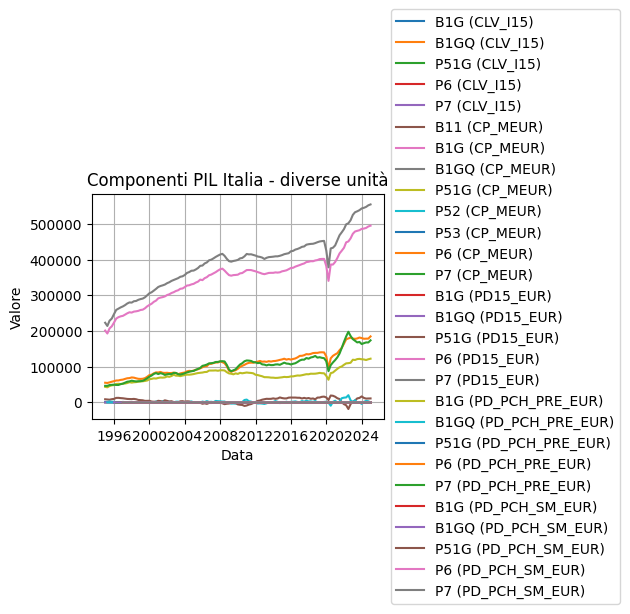

In [34]:
import matplotlib.pyplot as plt

for (unit, na_item), gdf in df.groupby(['unit_code', 'na_item_code']):
    gdf_sorted = gdf.sort_values('time')
    plt.plot(gdf_sorted['time'], gdf_sorted['value'], label=f"{na_item} ({unit})")

plt.title("Componenti PIL Italia - diverse unità")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(True)
plt.show()



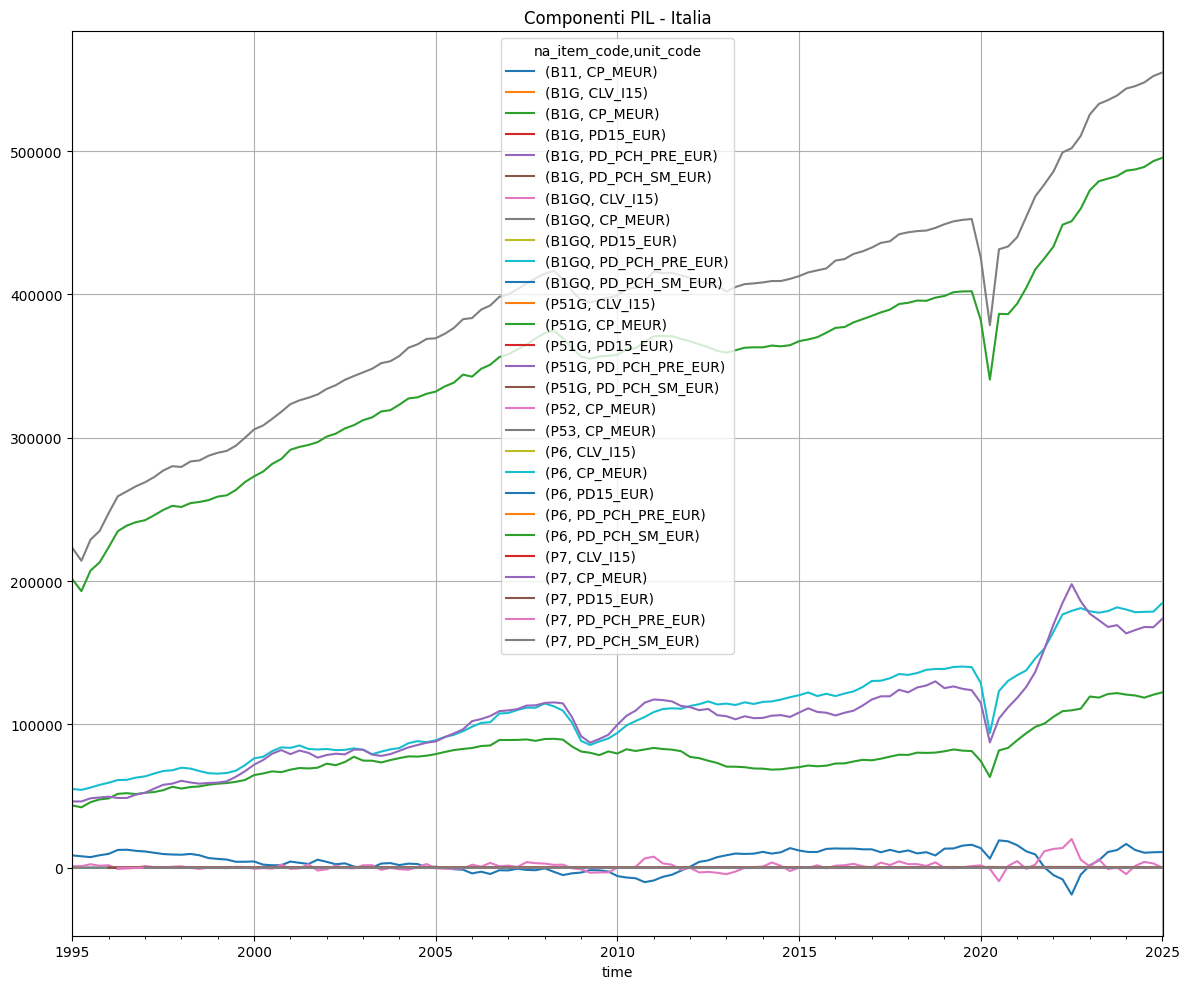

In [36]:
df_pivot = df.pivot_table(index='time', columns=['na_item_code', 'unit_code'], values='value')
df_pivot.plot(figsize=(12, 10))
plt.title("Componenti PIL - Italia")
plt.grid(True)
plt.tight_layout()
plt.show()


## Gross domestic product (GDP) at current market prices by NUTS 2 region

(120, 10)


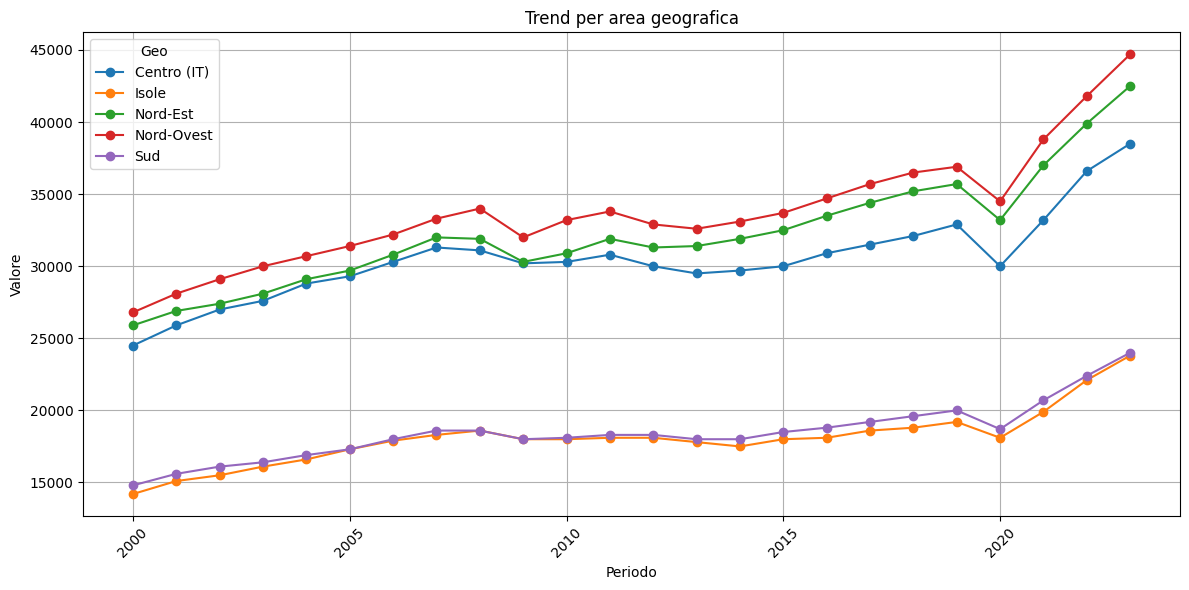

In [23]:
# _Gross domestic product (GDP) at current market prices by NUTS 2 region_
df = fetch_eurostat_data(
    dataset='nama_10r_2gdp',
    filters={
        'geo': [
            "ITC", # "ITC1", "ITC2", "ITC3", "ITC4", 
            "ITF", # "ITF1", "ITF2", "ITF3", "ITF4", "ITF5", "ITF6", 
            "ITG", # "ITG1", "ITG2", 
            "ITH", # "ITH1", "ITH2", "ITH3", "ITH4", "ITH5", 
            "ITI", # "ITI1", "ITI2", "ITI3", "ITI4"
            ],
        'unit': ["EUR_HAB"], # "MIO_EUR",
    }
)
print(df.shape)
df.sample(2)

df_pivot  = df.pivot_table(index='time_code', columns=['geo_label'], values='value').sort_values(by='time_code')
import matplotlib.pyplot as plt
# Plot
df_pivot.plot(figsize=(12, 6), marker='o')
plt.title('Trend per area geografica')
plt.xlabel('Periodo')
plt.ylabel('Valore')
plt.grid(True)
plt.legend(title='Geo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()